<a href="https://colab.research.google.com/github/SohaSaad2003/Human-_Activity-_Recognition/blob/main/Human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pafy youtube-dl moviepy -q

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 1-Download Dataset

In [ ]:
# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

For visualization, we will pick 20 random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( 20 random videos ) of the dataset.CodeText

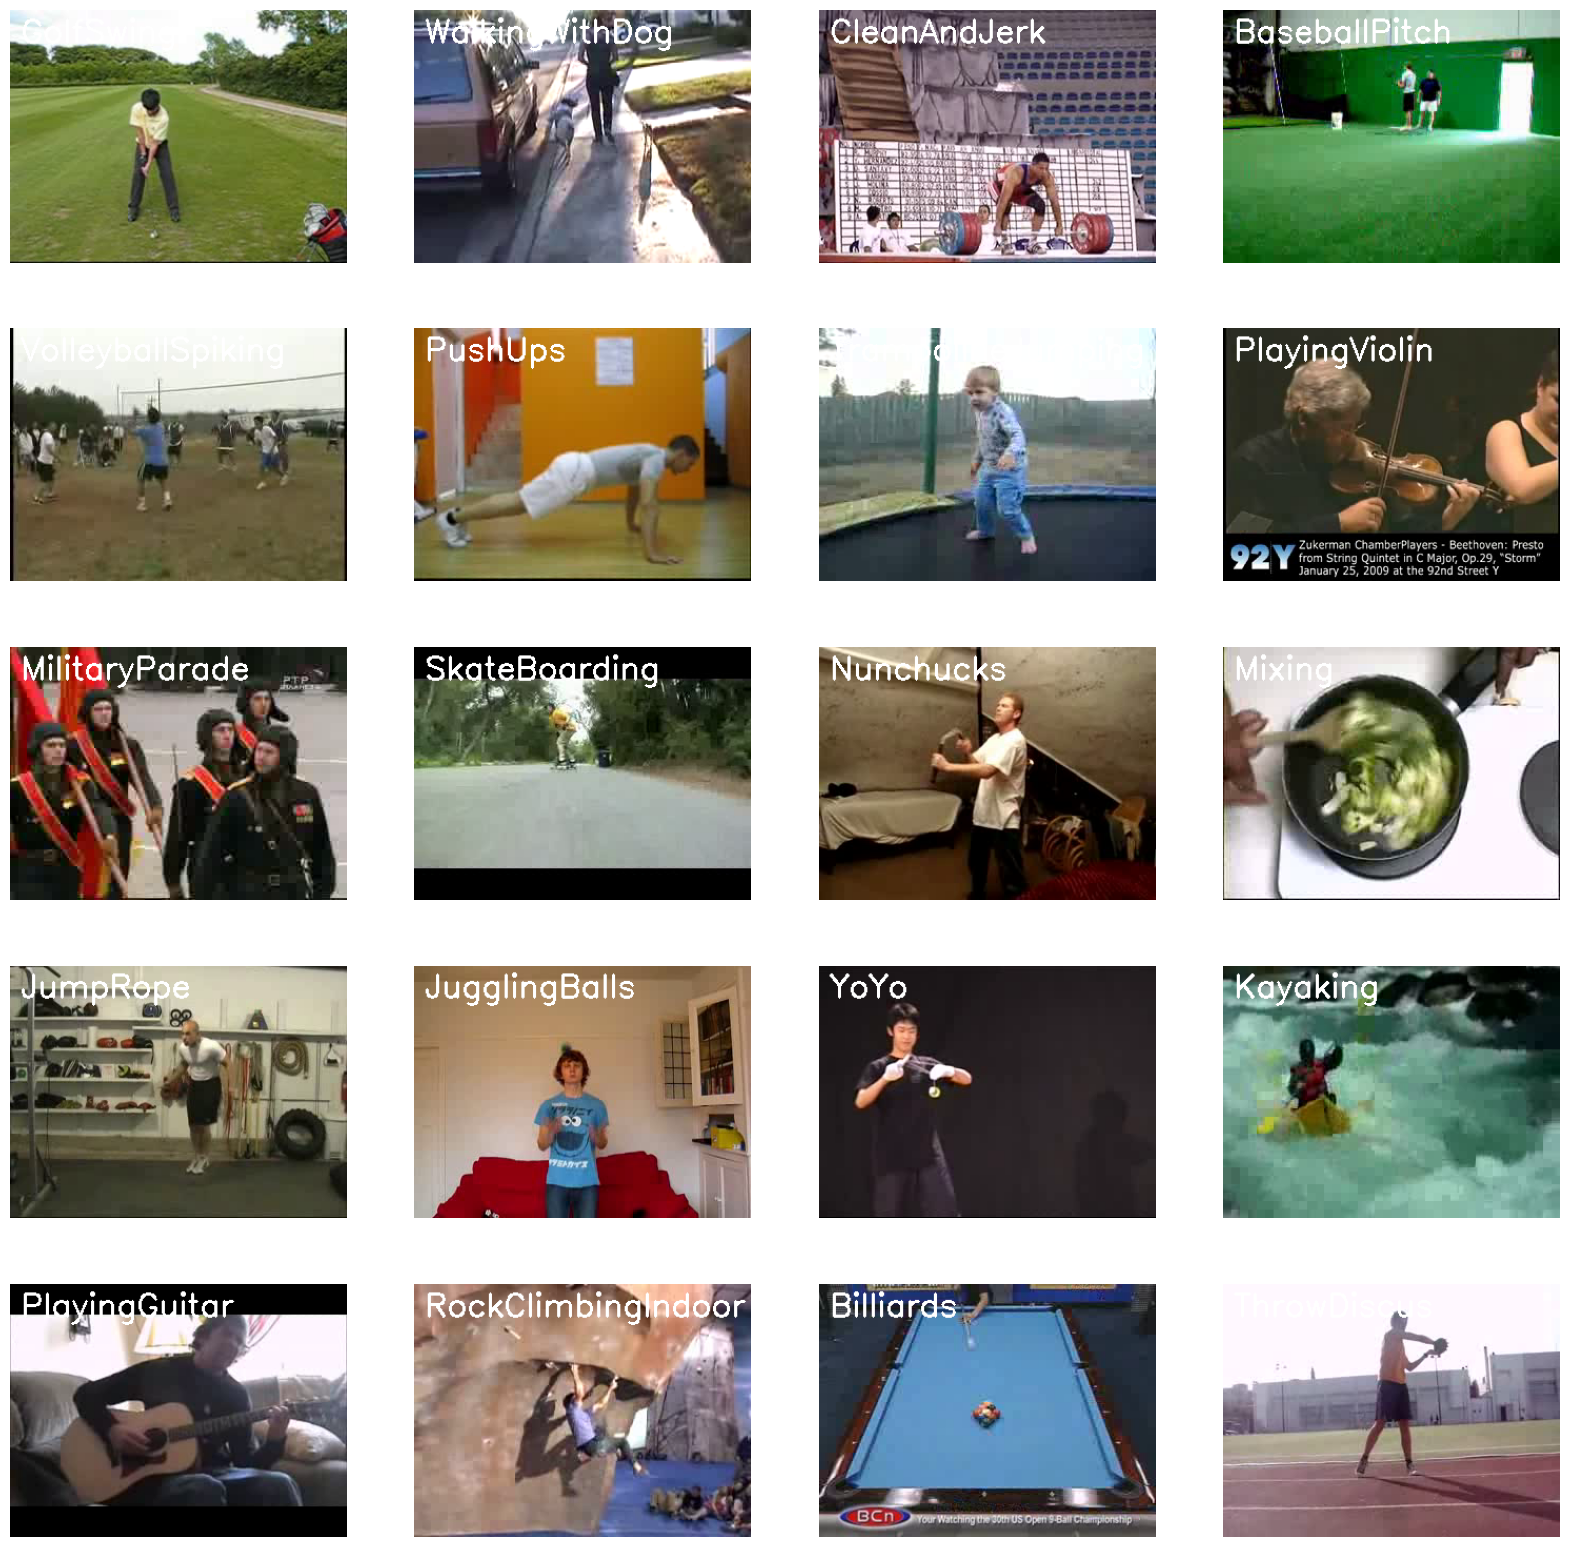

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')


random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2- Preprocess the Dataset

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"

CLASSES_LIST = ["WalkingWithDog", "YoYo", "Swing", "HorseRace","PlayingGuitar","PlayingPiano","PushUps","Mixing"]

In [ ]:
def frames_extraction(video_path):

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():


    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: YoYo
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingPiano
Extracting Data of Class: PushUps
Extracting Data of Class: Mixing


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

#3-  Split the Data into Train and Test

In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# 4- Step 4: Implement the ConvLSTM


In [ ]:
def create_convlstm_model():


    model = Sequential()


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))



    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          23,048 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,048 (218.94 KB)

 Trainable params: 56,048 (218.94 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 16,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1785 - loss: 2.0412 - val_accuracy: 0.2403 - val_loss: 2.0957
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.3732 - loss: 1.5893 - val_accuracy: 0.3896 - val_loss: 1.8777
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.4839 - loss: 1.3313 - val_accuracy: 0.5195 - val_loss: 1.6220
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5710 - loss: 1.1715 - val_accuracy: 0.5714 - val_loss: 1.4209
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5999 - loss: 0.9803 - val_accuracy: 0.5260 - val_loss: 1.5240
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6891 - loss: 0.8754 - val_accuracy: 0.5779 - val_loss: 1.4645
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7535 - loss: 0.6978 - val_accuracy: 0.5779 - val_loss: 1.4874
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7624 - loss: 0.6400 - val_accuracy: 0.5

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.8229 - loss: 0.7638


In [ ]:
# Save the model
convlstm_model.save('/content/drive/MyDrive/human_activity_Recognition.h5') # Changed 'model' to 'convlstm_model'

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):


    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

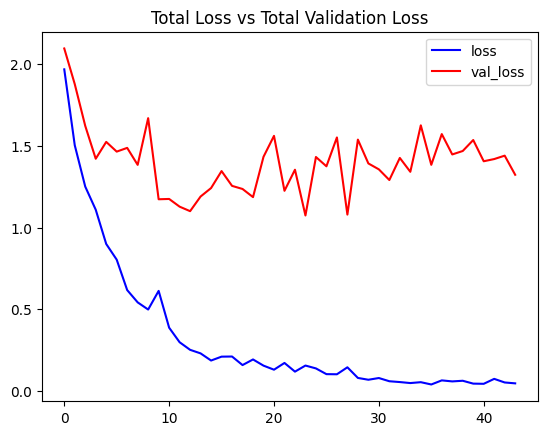

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


#Test

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/human_activity_Recognition.h5')


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import HTML, display
from moviepy.editor import ImageSequenceClip
import io
import base64
import tempfile # Import tempfile module


def predict_on_video(video_path):
    frames_list = []
    display_frames = []  # Store frames for display
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
        display_frames.append(frame)  # Store for display

    video_reader.release()

    # Pad or truncate frames to SEQUENCE_LENGTH
    frames_list = frames_list[:SEQUENCE_LENGTH]
    frames_list += [frames_list[-1]] * (SEQUENCE_LENGTH - len(frames_list))

    # Make prediction
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f"Predicted Activity: {predicted_class_name}")

    # Create video clip
    clip = ImageSequenceClip(display_frames, fps=25)  # Adjust fps as needed

    # Create a temporary file to write video to
    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as temp_file:
        temp_file_path = temp_file.name
        clip.write_videofile(temp_file_path, codec='libx264', logger=None)  # Use libx264 codec

    # Read video data from temporary file
    with open(temp_file_path, "rb") as f:
        video_data = base64.b64encode(f.read()).decode()

    # Remove the temporary file
    os.remove(temp_file_path)

    # Embed video in HTML5 video tag
    html_video = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display video
    display(HTML(html_video))

In [ ]:

# Get video path from user input
video_path = input("Enter the path to your video: ")

# Perform prediction
predict_on_video(video_path)

Enter the path to your video: /content/UCF50/PlayingGuitar/v_PlayingGuitar_g01_c03.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Activity: PlayingGuitar


In [ ]:
# Get video path from user input
video_path = input("Enter the path to your video: ")

# Perform prediction
predict_on_video(video_path)

Enter the path to your video: /content/UCF50/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Activity: WalkingWithDog


In [ ]:
# Get video path from user input
video_path = input("Enter the path to your video: ")

# Perform prediction
predict_on_video(video_path)

Enter the path to your video: /content/UCF50/Mixing/v_Mixing_g01_c04.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Activity: Mixing


In [ ]:
# Get video path from user input
video_path = input("Enter the path to your video: ")

# Perform prediction
predict_on_video(video_path)

Enter the path to your video: /content/UCF50/HorseRace/v_HorseRace_g02_c01.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Activity: HorseRace
